In [9]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [10]:
# Specify the input image size for VGG19
img_size = (224, 224)

# Data Augmentation (commented out for comparison)
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set the batch size
batch_size = 32

# Specify the paths to your train, validation, and test data
train_dir = 'D:\Zhanglab Data\CellData\chest_xray\\train'
val_dir = 'D:\Zhanglab Data\CellData\chest_xray\\val'
test_dir = 'D:\Zhanglab Data\CellData\chest_xray\\test'

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches using val_datagen generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',

)

# Flow test images in batches using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle = False
)

Found 5232 images belonging to 3 classes.
Found 312 images belonging to 3 classes.
Found 312 images belonging to 3 classes.


In [11]:
# Load the VGG-19 model with pretrained weights (excluding the top dense layers)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
model = models.Sequential()

# Add the VGG-19 base model
model.add(base_model)

# Flatten the output layer to 1 dimension
model.add(layers.Flatten())

# Add a fully connected layer with 256 hidden units and ReLU activation
model.add(layers.Dense(256, activation='relu'))

# Add a dropout layer for regularization
model.add(layers.Dropout(0.5))

# Add the final output layer with 4 classes for classification
model.add(layers.Dense(3, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 49,255,939
Trainable params: 25,691,139
Non-trainable params: 23,564,800
_________________________________________________________________


In [13]:
# Define the initial learning rate and the learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Define the optimizer with the learning rate schedule
opt = optimizers.Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with the specified number of epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=75,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stop]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/75
163/163 [==============================] - 48s 280ms/step - loss: 0.3713 - accuracy: 0.8510 - val_loss: 0.7158 - val_accuracy: 0.8333
Epoch 2/75
163/163 [==============================] - 44s 270ms/step - loss: 0.3424 - accuracy: 0.8569 - val_loss: 1.1540 - val_accuracy: 0.7812
Epoch 3/75
163/163 [==============================] - 44s 270ms/step - loss: 0.3672 - accuracy: 0.8575 - val_loss: 0.7817 - val_accuracy: 0.8472
Epoch 4/75
163/163 [==============================] - 44s 270ms/step - loss: 0.2866 - accuracy: 0.8769 - val_loss: 0.9276 - val_accuracy: 0.8333
Epoch 5/75
163/163 [==============================] - 44s 271ms/step - loss: 0.2867 - accuracy: 0.8881 - val_loss: 1.1047 - val_accuracy: 0.8368
Epoch 6/75
163/163 [==============================] - 44s 271ms/step - loss: 0.2793 - accuracy: 0.8825 - val_loss: 0.7065 - val_accuracy: 0.8438
Epoch 7/75
163/163 [==============================] - 45s 274ms/step - loss: 0.2185 - accuracy: 0.9085 - val_loss: 1.1627 - val_ac

In [14]:
from sklearn.metrics import classification_report

# Get predictions on the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Convert predictions to class labels
y_pred_labels = tf.argmax(y_pred, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_labels, target_names=class_labels, digits=4))

312/312 [==============================] - 5s 15ms/step

Classification Report:
                     precision    recall  f1-score   support

             NORMAL     0.9651    0.7094    0.8177       117
PNEUMONIA-BACTERIAL     0.8194    0.9752    0.8906       121
    PNEUMONIA-VIRAL     0.6829    0.7568    0.7179        74

           accuracy                         0.8237       312
          macro avg     0.8225    0.8138    0.8087       312
       weighted avg     0.8417    0.8237    0.8223       312



312/312 [==============================] - 5s 15ms/step


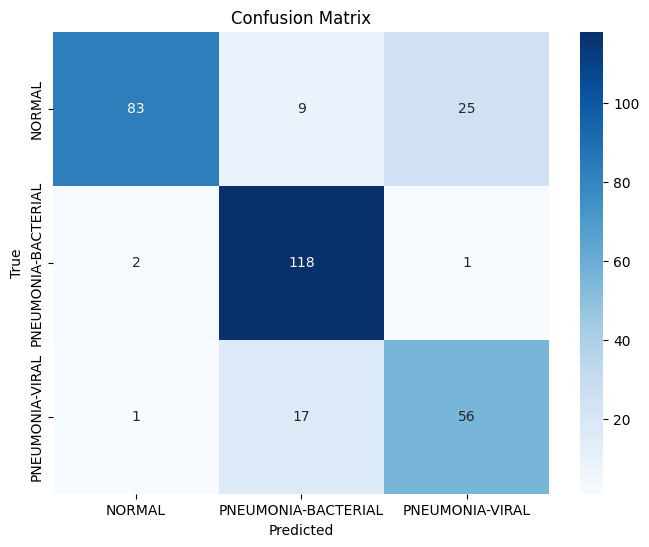

In [15]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Predict the classes for the test set
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Get the true classes for the test set
y_true = test_generator.classes

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
class_names = ['NORMAL', 'PNEUMONIA-BACTERIAL', 'PNEUMONIA-VIRAL']  # Adjust these based on your actual class names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
